In [72]:
import pandas as pd
import numpy as np
import onnxruntime as rt
from sklearn.metrics import accuracy_score, recall_score, f1_score
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
import random

leeftijd - persoon_leeftijd_bij_onderzoek (18-67)
geslacht - persoon_geslacht_vrouw (binary)
taaleis - persoonlijke_eigenschappen_taaleis_voldaan (binary)
wijk - adres_recentste_wijk_... (binary)


In [73]:
#simple statistical parity as explained in Lighthouse report.
def simple_statistical_parity_binary(feature_name, test_data, session):
    data_zero = test_data[test_data[feature_name] == 0]
    data_one = test_data[test_data[feature_name] == 1]
    
    X_zero = data_zero.drop(['checked'], axis=1)
    X_one = data_one.drop(['checked'], axis=1)
    
    y_pred_onnx_zero =  session.run(None, {'X': X_zero.values.astype(np.float32)})
    y_pred_onnx_one =  session.run(None, {'X': X_one.values.astype(np.float32)})
    
    parity_zero = y_pred_onnx_zero[1].sum() / len(y_pred_onnx_zero[1])
    parity_one = y_pred_onnx_one[1].sum() / len(y_pred_onnx_one[1])

    print('========')
    print(f'{feature_name}')
    print('Parity (0): ', parity_zero)
    print('Parity (1): ', parity_one)
    #print('')
    #print(f'Accuracy (0): {accuracy_score(data_zero["checked"], y_pred_onnx_zero[1])}')
    #print(f'Accuracy (1): {accuracy_score(data_one["checked"], y_pred_onnx_one[1])}')
    #print('')
    #print(f'Recall (0): {recall_score(data_zero["checked"], y_pred_onnx_zero[1])}')
    #print(f'Recall (1): {recall_score(data_one["checked"], y_pred_onnx_one[1])}')
    #print('')
    #print(f'F1 score (0): {f1_score(data_zero["checked"], y_pred_onnx_zero[1])}')
    #print(f'F1 score (1): {f1_score(data_one["checked"], y_pred_onnx_one[1])}')
    #print('')

In [74]:
def simple_statistical_parity_age(test_data, session):
    data_bin_18_25 = test_data[(test_data['persoon_leeftijd_bij_onderzoek'] >= 18) & (test_data['persoon_leeftijd_bij_onderzoek'] <= 25)]
    data_bin_26_45 = test_data[(test_data['persoon_leeftijd_bij_onderzoek'] >= 26) & (test_data['persoon_leeftijd_bij_onderzoek'] <= 45)]
    data_bin_46_65 = test_data[(test_data['persoon_leeftijd_bij_onderzoek'] >= 46) & (test_data['persoon_leeftijd_bij_onderzoek'] <= 65)]
    
    X_18_25 = data_bin_18_25.drop(['checked'], axis=1)
    X_26_45 = data_bin_26_45.drop(['checked'], axis=1)
    X_46_65 = data_bin_46_65.drop(['checked'], axis=1)
    
    y_pred_onnx_18_25 =  session.run(None, {'X': X_18_25.values.astype(np.float32)})
    y_pred_onnx_26_45 =  session.run(None, {'X': X_26_45.values.astype(np.float32)})
    y_pred_onnx_46_65 =  session.run(None, {'X': X_46_65.values.astype(np.float32)})
    
    parity_18_25 = y_pred_onnx_18_25[1].sum() / len(y_pred_onnx_18_25[1])
    parity_26_45 = y_pred_onnx_26_45[1].sum() / len(y_pred_onnx_26_45[1])
    parity_46_65 = y_pred_onnx_46_65[1].sum() / len(y_pred_onnx_46_65[1])

    print('========')
    print('Ages')
    print('Parity (18-25): ', parity_18_25)
    print('Parity (26-45): ', parity_26_45)
    print('Parity (46-65): ', parity_46_65)
    #print('')
    #print(f'Accuracy (0): {accuracy_score(data_zero["checked"], y_pred_onnx_zero[1])}')
    #print(f'Accuracy (1): {accuracy_score(data_one["checked"], y_pred_onnx_one[1])}')
    #print('')
    #print(f'Recall (0): {recall_score(data_zero["checked"], y_pred_onnx_zero[1])}')
    #print(f'Recall (1): {recall_score(data_one["checked"], y_pred_onnx_one[1])}')
    #print('')
    #print(f'F1 score (0): {f1_score(data_zero["checked"], y_pred_onnx_zero[1])}')
    #print(f'F1 score (1): {f1_score(data_one["checked"], y_pred_onnx_one[1])}')
    #print('')

In [75]:
data = pd.read_csv('data/all_data_scaled.csv')
test_data = data.drop(['Ja', 'Nee'], axis=1)

district_column_names = np.array([s for s in list(data.columns.values) if s.startswith('adres_recentste_wijk_')])

new_session = rt.InferenceSession('./model/ridge_regression_model.onnx')
simple_statistical_parity_binary('persoon_geslacht_vrouw', test_data, new_session)
simple_statistical_parity_binary('persoonlijke_eigenschappen_taaleis_voldaan', test_data, new_session)
simple_statistical_parity_age(test_data, new_session)
for district in district_column_names:
    simple_statistical_parity_binary(district, test_data, new_session)

persoon_geslacht_vrouw
Parity (0):  0.09433455251175636
Parity (1):  0.09081964611600413
persoonlijke_eigenschappen_taaleis_voldaan
Parity (0):  0.12388617418798506
Parity (1):  0.0984515077424613
Ages
Parity (18-25):  0.4307692307692308
Parity (26-45):  0.17880390083421455
Parity (46-65):  0.0435316876133004
adres_recentste_wijk_charlois
Parity (0):  0.09509582766518003
Parity (1):  0.07196477551609644
adres_recentste_wijk_delfshaven
Parity (0):  0.09112122480606347
Parity (1):  0.10219513571468879
adres_recentste_wijk_feijenoord
Parity (0):  0.09163565314477112
Parity (1):  0.09738010657193606
adres_recentste_wijk_ijsselmonde
Parity (0):  0.09210071884663266
Parity (1):  0.10464058234758872
adres_recentste_wijk_kralingen_c
Parity (0):  0.09383602440477148
Parity (1):  0.06664352655328011
adres_recentste_wijk_noord
Parity (0):  0.09248273315156325
Parity (1):  0.09952433223563849
adres_recentste_wijk_other
Parity (0):  0.0934963681247447
Parity (1):  0.08702404233291154
adres_recentst

In [76]:
# controlled statistical parity, create two dataset were a given feature is set to 0 or 1 for all rows
# (does not support features with more than 2 values)
def controlled_statistical_parity_binary(feature_name, test_data, session):
    data_all_zero = test_data.copy()
    data_all_zero[feature_name] = 0
    
    data_all_one = test_data.copy()
    data_all_one[feature_name] = 1
    
    X_zero = data_all_zero.drop(['checked'], axis=1)
    X_one = data_all_one.drop(['checked'], axis=1)
    
    y_pred_onnx_zero =  session.run(None, {'X': X_zero.values.astype(np.float32)})
    y_pred_onnx_one =  session.run(None, {'X': X_one.values.astype(np.float32)})
    
    parity_zero = y_pred_onnx_zero[1].sum() / len(y_pred_onnx_zero[1]) #number of high-risk divided by total group size
    parity_one = y_pred_onnx_one[1].sum() / len(y_pred_onnx_one[1])

    print("======")   
    print(f'{feature_name}')
    print('Parity (0): ', parity_zero)
    print('Parity (1): ', parity_one)

In [77]:
def controlled_statistical_parity_age(test_data, session):
    data_all_18_25 = test_data.copy()
    data_all_18_25['persoon_leeftijd_bij_onderzoek'] = 21
    
    data_all_26_45 = test_data.copy()
    data_all_26_45['persoon_leeftijd_bij_onderzoek'] = 36
    
    data_all_46_65 = test_data.copy()
    data_all_46_65['persoon_leeftijd_bij_onderzoek'] = 56
    
    X_18_25 = data_all_18_25.drop(['checked'], axis=1)
    X_26_45 = data_all_26_45.drop(['checked'], axis=1)
    X_46_65 = data_all_46_65.drop(['checked'], axis=1)
    
    y_pred_onnx_18_25 = session.run(None, {'X': X_18_25.values.astype(np.float32)})
    y_pred_onnx_26_45 = session.run(None, {'X': X_26_45.values.astype(np.float32)})
    y_pred_onnx_46_65 = session.run(None, {'X': X_46_65.values.astype(np.float32)})
    
    parity_18_25 = y_pred_onnx_18_25[1].sum() / len(y_pred_onnx_18_25[1]) #number of high-risk divided by total group size
    parity_26_45 = y_pred_onnx_26_45[1].sum() / len(y_pred_onnx_26_45[1])
    parity_46_65 = y_pred_onnx_46_65[1].sum() / len(y_pred_onnx_46_65[1])
    
    print("======")   
    print('Age')

    print('Parity (18-25): ', parity_18_25)
    print('Parity (26-45): ', parity_26_45)
    print('Parity (46-65): ', parity_46_65)
    print('')

In [ ]:
controlled_statistical_parity_binary('persoon_geslacht_vrouw', test_data, new_session)
controlled_statistical_parity_binary('persoonlijke_eigenschappen_taaleis_voldaan', test_data, new_session)
controlled_statistical_parity_age(test_data, new_session)

persoon_geslacht_vrouw
Parity (0):  0.0900076923076923
Parity (1):  0.09556923076923077
persoonlijke_eigenschappen_taaleis_voldaan
Parity (0):  0.1054
Parity (1):  0.06595384615384615
Age
Parity (18-25):  0.1760076923076923
Parity (26-45):  0.11644615384615385
Parity (46-65):  0.062

adres_recentste_wijk_charlois
Parity (0):  0.09347692307692308
Parity (1):  0.0845
adres_recentste_wijk_delfshaven
Parity (0):  0.09170769230769231
Parity (1):  0.09775384615384615
adres_recentste_wijk_feijenoord
Parity (0):  0.0935
Parity (1):  0.08894615384615384
adres_recentste_wijk_ijsselmonde
Parity (0):  0.09263076923076922
Parity (1):  0.09244615384615384
adres_recentste_wijk_kralingen_c
Parity (0):  0.09282307692307692
Parity (1):  0.08785384615384616
adres_recentste_wijk_noord
Parity (0):  0.09251538461538461
Parity (1):  0.09844615384615385
adres_recentste_wijk_other
Parity (0):  0.0944923076923077
Parity (1):  0.08144615384615385
adres_recentste_wijk_prins_alexa
Parity (0):  0.0914
Parity (1):  

In [86]:
#controlled statistical parity for the different districts
def controlled_statistical_parity_districts(test_data, session):
    district_column_names = np.array([s for s in list(test_data.columns.values) if s.startswith('adres_recentste_wijk_')])
    district_full_names = np.array(['Charlois', 'Delfshaven', 'Feijenoord', 'Ijsselmonde', 'Kralingen-Crooswijk',
                       'Noord', 'Other', 'Prins Alexander', 'Stadscentrum'])
    
    data_list = []
    for district in district_column_names:
        df_temp = test_data.copy()
        df_temp[district] = 1
        for other_district in district_column_names:
            if other_district != district:
                df_temp[other_district] = 0
        data_list.append(df_temp)
        
    for i, d in enumerate(data_list):
        X = d.drop(['checked'], axis=1)
        y_pred_onnx =  session.run(None, {'X': X.values.astype(np.float32)})
        parity = y_pred_onnx[1].sum() / len(y_pred_onnx[1]) #number of high-risk divided by total group size
        print(f'Parity ({district_full_names[i]}): {parity}')

    print('')

In [87]:
controlled_statistical_parity_districts(test_data, new_session)

Parity (Charlois): 0.08513076923076923
Parity (Delfshaven): 0.10026153846153846
Parity (Feijenoord): 0.08946153846153847
Parity (Ijsselmonde): 0.09392307692307693
Parity (Kralingen-Crooswijk): 0.08887692307692308
Parity (Noord): 0.10021538461538461
Parity (Other): 0.0812
Parity (Prins Alexander): 0.12864615384615385
Parity (Stadscentrum): 0.09331538461538462



In [ ]:
def percentage_per_decile_gender(feature_name, test_data):
    session = new_session
    X = test_data.drop(['checked'], axis=1)
    y_pred_onnx = session.run(None, {'X': X.values.astype(np.float32)})
    
    sorted_data = test_data.copy()
    sorted_data['predicted_risk'] = y_pred_onnx[0].flatten()
    sorted_data = sorted_data.sort_values(by='predicted_risk', ascending=True).reset_index(drop=True)

    sorted_data['decile'] = pd.qcut(sorted_data['predicted_risk'], q=10, labels=False)
    
    group_0 = sorted_data[sorted_data[feature_name] == 0]
    group_1 = sorted_data[sorted_data[feature_name] == 1]
    
    decile_counts_0 = group_0['decile'].value_counts(normalize=True).sort_index() * 100
    decile_counts_1 = group_1['decile'].value_counts(normalize=True).sort_index() * 100
    
    plt.figure(figsize=(10, 6))
    plt.ylim(0, 14)
    # Plot line for Feature = 0
    plt.plot(decile_counts_0.index, decile_counts_0, label='Male', marker='o', color='skyblue', linewidth=2)

    # Plot line for Feature = 1
    plt.plot(decile_counts_1.index, decile_counts_1, label='Female', marker='o', color='orange', linewidth=2)

    # Formatting the plot
    plt.xlabel('Deciles of Gender', fontsize=12)
    plt.ylabel('Percentage of Rows', fontsize=12)
    plt.title('Percentage of Rows per Decile by Gender', fontsize=14)
    plt.xticks(ticks=np.arange(10), labels=[f'{i+1}' for i in range(10)])
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show plot
    plt.show()

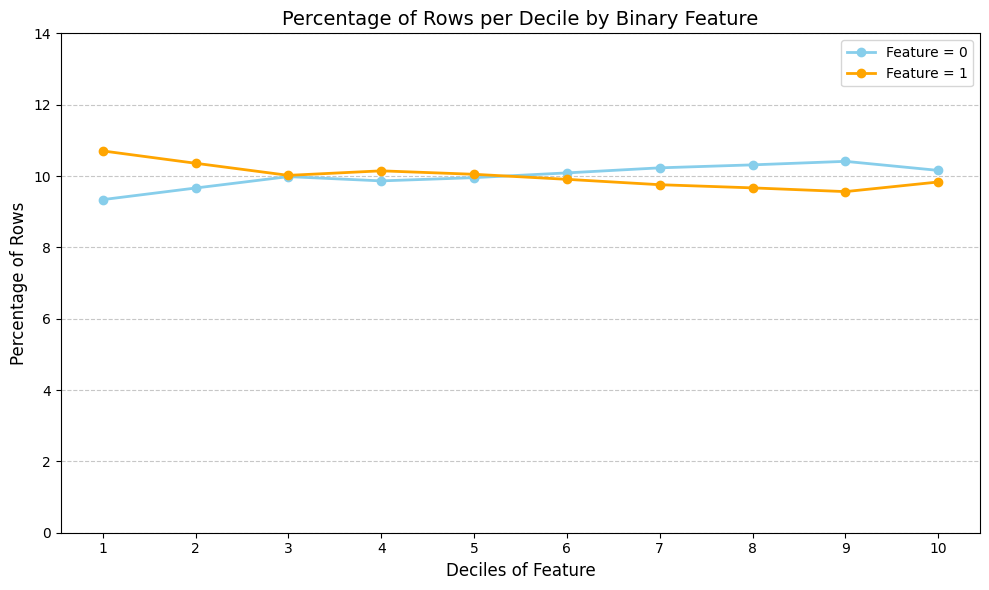

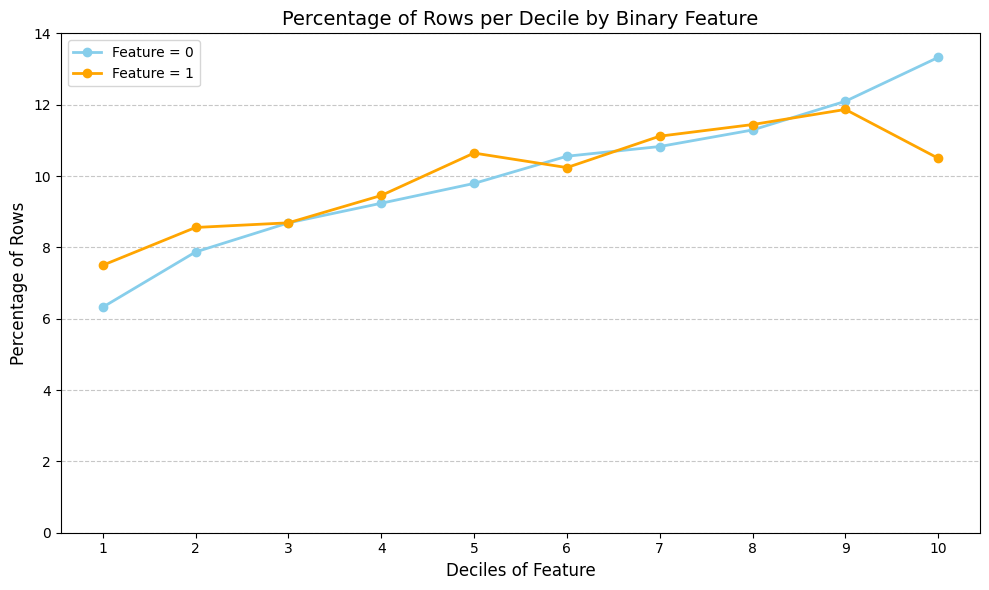

In [ ]:
percentage_per_decile_gender('persoon_geslacht_vrouw', test_data)

In [98]:
def percentage_per_decile_language(feature_name, test_data):
    session = new_session
    X = test_data.drop(['checked'], axis=1)
    y_pred_onnx = session.run(None, {'X': X.values.astype(np.float32)})
    
    sorted_data = test_data.copy()
    sorted_data['predicted_risk'] = y_pred_onnx[0].flatten()
    sorted_data = sorted_data.sort_values(by='predicted_risk', ascending=True).reset_index(drop=True)

    sorted_data['decile'] = pd.qcut(sorted_data['predicted_risk'], q=10, labels=False)
    
    group_0 = sorted_data[sorted_data[feature_name] == 0]
    group_1 = sorted_data[sorted_data[feature_name] == 1]
    
    decile_counts_0 = group_0['decile'].value_counts(normalize=True).sort_index() * 100
    decile_counts_1 = group_1['decile'].value_counts(normalize=True).sort_index() * 100
    
    plt.figure(figsize=(10, 6))
    plt.ylim(0, 14)
    # Plot line for Feature = 0
    plt.plot(decile_counts_0.index, decile_counts_0, label='Language requirement not met', marker='o', color='skyblue', linewidth=2)

    # Plot line for Feature = 1
    plt.plot(decile_counts_1.index, decile_counts_1, label='Language requirement met', marker='o', color='orange', linewidth=2)

    # Formatting the plot
    plt.xlabel('Deciles of Language Requirement', fontsize=12)
    plt.ylabel('Percentage of Rows', fontsize=12)
    plt.title('Percentage of Rows per Decile by Language Requirement', fontsize=14)
    plt.xticks(ticks=np.arange(10), labels=[f'{i+1}' for i in range(10)])
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show plot
    plt.show()

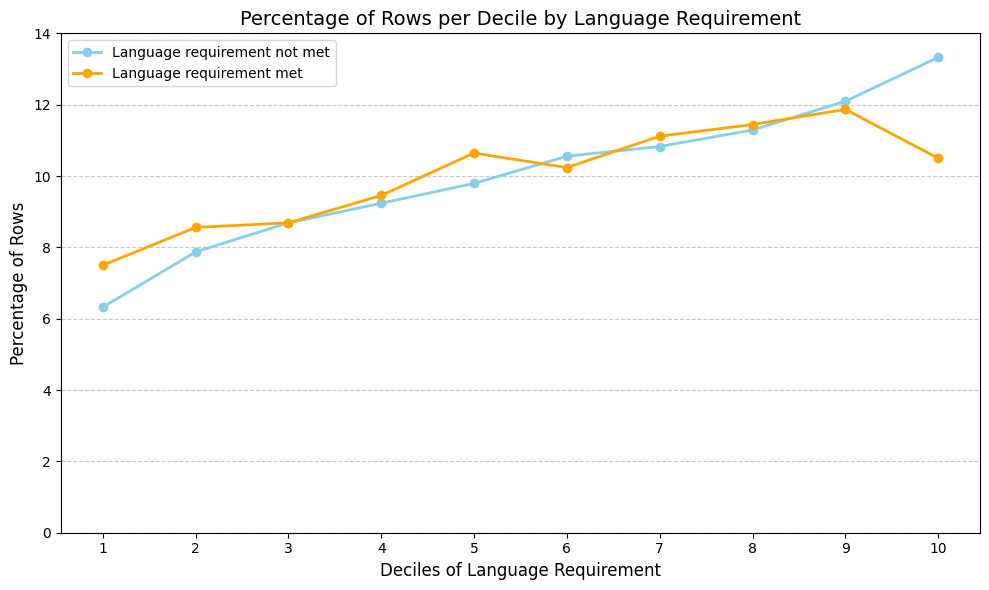

In [99]:
percentage_per_decile_language('persoonlijke_eigenschappen_taaleis_voldaan', test_data)

In [96]:
def percentage_per_decile_age(test_data):
    session = new_session
    X = test_data.drop(['checked'], axis=1)
    y_pred_onnx = session.run(None, {'X': X.values.astype(np.float32)})
    
    sorted_data = test_data.copy()
    sorted_data['predicted_risk'] = y_pred_onnx[0].flatten()
    sorted_data = sorted_data.sort_values(by='predicted_risk', ascending=True).reset_index(drop=True)

    sorted_data['decile'] = pd.qcut(sorted_data['predicted_risk'], q=10, labels=False)
    
    data_bin_18_25 = sorted_data[(sorted_data['persoon_leeftijd_bij_onderzoek'] >= 18) & (sorted_data['persoon_leeftijd_bij_onderzoek'] <= 25)]
    data_bin_26_45 = sorted_data[(sorted_data['persoon_leeftijd_bij_onderzoek'] >= 26) & (sorted_data['persoon_leeftijd_bij_onderzoek'] <= 45)]
    data_bin_46_65 = sorted_data[(sorted_data['persoon_leeftijd_bij_onderzoek'] >= 46) & (sorted_data['persoon_leeftijd_bij_onderzoek'] <= 65)]
    
    decile_counts_18_25 = data_bin_18_25['decile'].value_counts(normalize=True).sort_index() * 100
    decile_counts_26_45 = data_bin_26_45['decile'].value_counts(normalize=True).sort_index() * 100
    decile_counts_46_65 = data_bin_46_65['decile'].value_counts(normalize=True).sort_index() * 100
    
    plt.figure(figsize=(10, 6))
    #plt.ylim(0, 240)
    # Plot line for Feature = 0
    plt.plot(decile_counts_18_25.index, decile_counts_18_25, label='18-25', marker='o', color='skyblue', linewidth=2)

    # Plot line for Feature = 1
    plt.plot(decile_counts_26_45.index, decile_counts_26_45, label='26-45', marker='o', color='orange', linewidth=2)
    
    # Plot line for Feature = 2
    plt.plot(decile_counts_46_65.index, decile_counts_46_65, label='46-65', marker='o', color='brown', linewidth=2)

    # Formatting the plot
    plt.xlabel('Deciles of Ages', fontsize=12)
    plt.ylabel('Percentage of Rows', fontsize=12)
    plt.title('Percentage of Rows per Decile by Age', fontsize=14)
    plt.xticks(ticks=np.arange(10), labels=[f'{i+1}' for i in range(10)])
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show plot
    plt.show()

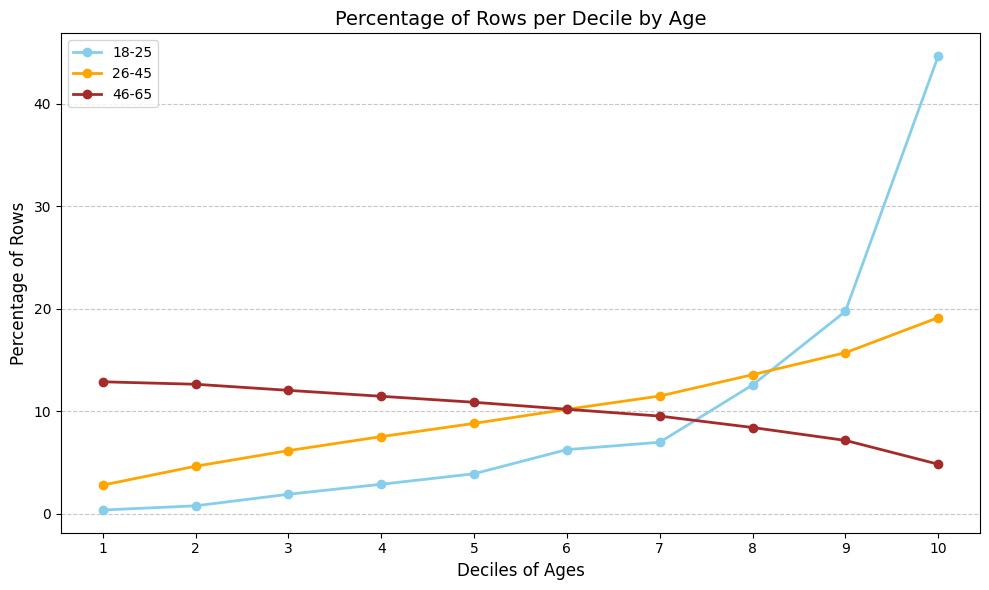

In [97]:
percentage_per_decile_age(test_data)